In [1]:
import pandas as pd
import numpy as np
import importlib
import os
from Utils import model_data_engineering
# from Utils import Models 
from Utils import preprocessing 
from Utils import plotting

# reload
importlib.reload(model_data_engineering)
importlib.reload(preprocessing)
importlib.reload(plotting)
# importlib.reload(Models)


# importing modules
from Utils.preprocessing import combine_csv_files
from Utils.preprocessing import perform_downsampling
from Utils.plotting import plot
from Utils.featureEngineering import creating_more_features
from Utils.model_data_engineering import create_Features_Scaling
from sklearn.model_selection import train_test_split


from Utils import Evaluation
importlib.reload(Evaluation)

from Utils.Evaluation import calculate_errors

from Utils import model_data_engineering
importlib.reload(model_data_engineering)
from Utils.model_data_engineering import create_Features_Scaling

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import os
from sklearn.model_selection import train_test_split
from darts.models.forecasting.xgboost import XGBModel 
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler


In [2]:
# # # Example usage
# df = combine_csv_files('../raw_data/', '../preprocessed_data/', saveFile=True)
# df.head()

Processing: 100%|██████████| 472/472 [00:47<00:00, 10.03it/s]


Files combined successfully.


,Timestamp,Summe
0,2014-03-12 07:52:42,21.425238
1,2014-03-12 07:52:47,23.532056
2,2014-03-12 07:52:53,16.978532
3,2014-03-12 07:52:59,19.253268
4,2014-03-12 07:53:04,856.854355


In [3]:
# Example usage
df = pd.read_csv('../preprocessed_data/combined.csv')

In [4]:
hourly_df = perform_downsampling(df, freq='1H',aggregation_func='mean')


In [5]:
x_feature_name = 'Timestamp'
y_feature_name = 'Summe'
title = 'Hourly Plot '
plot(hourly_df,x_feature_name,y_feature_name,title = title,preview=True)

# XGB Model

In [109]:
series = TimeSeries.from_dataframe(hourly_df,'Timestamp','Summe',freq='1H')

train_series ,valid_series = TimeSeries.split_before(series,0.8)
train_series_input,valid_series_input = TimeSeries.split_before(train_series,0.2)
xgb_model =  XGBModel(lags=96,
                  lags_past_covariates=12,
                  lags_future_covariates =None,
                  output_chunk_length = 24,
                  add_encoders={
                                'cyclic': {'future': ['month']},
                                'datetime_attribute': {'future': ['hour', 'dayofweek']},
                                'position': {'past': ['relative'], 'future': ['relative']},
                                'custom': {'past': [lambda idx: (idx.year - 2014) / 50]},
                                'transformer': Scaler()
                            },
                  likelihood =  None , 
                  random_state = 1999,
                  quantiles= None,
                  multi_models = True,
                  use_static_covariates = False,
                  n_estimators= 100,
                    max_depth= 7,
                    learning_rate= 0.2,
                    min_child_weight= 3,
                    subsample= 0.7
              )

In [110]:
xgb_model.fit(train_series_input,val_series=valid_series_input)

/home/iffi/anaconda3/lib/python3.9/site-packages/darts/utils/data/tabularization.py:1242: UserWarning:

`lags_past_covariates` was specified without accompanying `past_covariates` and, thus, will be ignored.

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[0]	validation_0-rmse:115.01947
[1]	validation_0-rmse:109.71420
[2]	validation_0-rmse:106.88454
[3]	validation_0-rmse:105.09707
[4]	validation_0-rmse:103.85967
[5]	validation_0-rmse:102.67482
[6]	validation_0-rmse:102.49492
[7]	validation_0-rmse:102.28598
[8]	validation_0-rmse:102.19318
[9]	validation_0-rmse:101.99221
[10]	validation_0-rmse:102.10127
[11]	validation_0-rmse:102.33553
[12]	validation_0-rmse:102.56292
[13]	validation_0-rmse:102.66605
[14]	validation_0-rmse:102.89802
[15]	validation_0-rmse:102.96750
[16]	validation_0-rmse:103.07617
[17]	validation_0-rmse:103.25497
[18]	validation_0-rmse:103.21451
[19]	validation_0-rmse:103.24264
[20]	validation_0-rmse:103.07120
[21]	validation_0-rmse:103.08554
[22]	validation_0-rmse:103.05178
[23]	validation_0-rmse:103.23588
[24]	validation_0-rmse:103.38495
[25]	validation_0-rmse:103.43100
[26]	validation_0-rmse:103.49375
[27]	validation_0-rmse:103.52645
[28]	validation_0-rmse:103.44592
[29]	validation_0-rmse:103.69645
[30]	validation_0-rm

XGBModel(lags=96, lags_past_covariates=12, lags_future_covariates=None, output_chunk_length=24, add_encoders={'cyclic': {'future': ['month']}, 'datetime_attribute': {'future': ['hour', 'dayofweek']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function <lambda> at 0x7f111d0a53a0>]}, 'transformer': Scaler}, likelihood=None, quantiles=None, random_state=1999, multi_models=True, use_static_covariates=False, n_estimators=100, max_depth=7, learning_rate=0.2, min_child_weight=3, subsample=0.7)

In [112]:
from tqdm import tqdm

In [114]:
from darts.metrics import mae,mape
counter = 0
input_window = 96
horizan = 24
maeErrorList = []
mapeErrorList = []
os.makedirs('../plots',exist_ok=True)
for i in tqdm(range(0 , len(valid_series)-input_window)):
    input_series = valid_series[i:input_window+i]
    

    predicted = xgb_model.predict(n=24 , series= input_series)
    actual = valid_series[input_window+i:input_window+i+horizan]
    
    maeError = mae(predicted, actual)
    mapeError = mape(predicted, actual)

    maeErrorList.append(maeError)
    mapeErrorList.append(mapeError)

    
    
    # plt.figure(figsize=(20,5))
    # plt.plot(predicted.time_index, predicted.values(), label='Prediction', marker='o')
    # plt.plot(actual.time_index, actual.values(), label='Actual', marker='o')

    # plt.title(f'MAE : {np.round(maeError, 2)}')
    # plt.legend()

    # # Customize x-axis tick labels to show the full date
    # plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability

    # plt.savefig(f'../plots/{i}.png')
    # plt.show()
    # plt.clf()
    # break

    # counter+=1
    # if counter>5:
    #     break
    

100%|██████████| 2183/2183 [01:34<00:00, 23.18it/s]


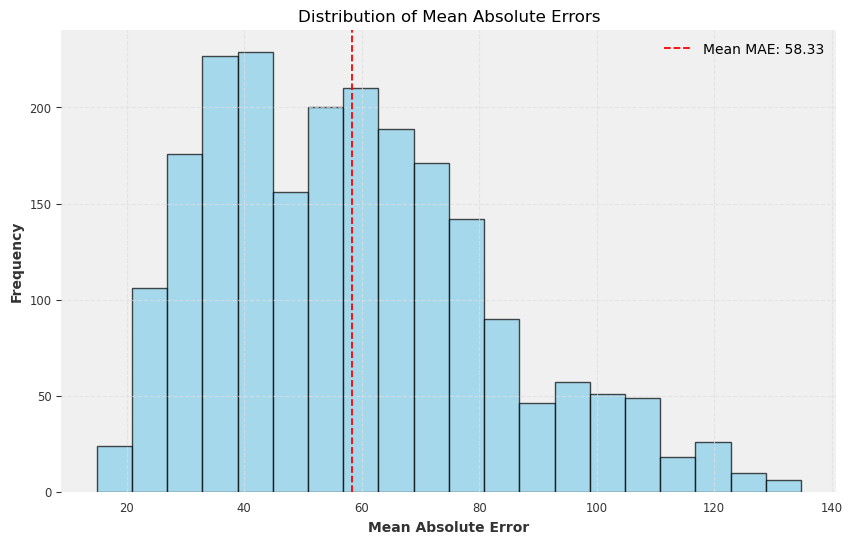

In [115]:
import matplotlib.pyplot as plt

# Your existing code here...

# Calculate the mean of the MAE errors
mean_mae = sum(maeErrorList) / len(maeErrorList)

# Plot the histogram of MAE errors
plt.figure(figsize=(10, 6))
plt.hist(maeErrorList, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Absolute Errors')
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for the mean
plt.axvline(mean_mae, color='red', linestyle='--', label=f'Mean MAE: {mean_mae:.2f}')
plt.legend()

# Add a background color to the plot
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light gray background

plt.savefig(f'../plots/mae_histogram_with_mean_{mean_mae}.png')
plt.show()


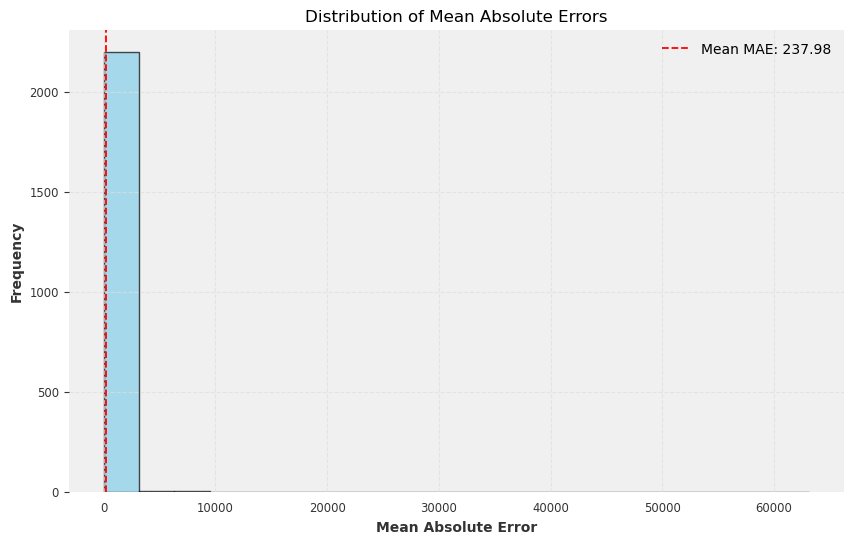

In [79]:
import matplotlib.pyplot as plt

# Your existing code here...

# Calculate the mean of the MAE errors
mean_mape = sum(mapeErrorList) / len(mapeErrorList)

# Plot the histogram of MAE errors
plt.figure(figsize=(10, 6))
plt.hist(mapeErrorList, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Absolute Errors')
plt.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line for the mean
plt.axvline(mean_mape, color='red', linestyle='--', label=f'Mean MAE: {mean_mape:.2f}')
plt.legend()

# Add a background color to the plot
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light gray background

plt.savefig('../plots/mae_histogram_with_mean.png')
plt.show()


In [104]:
from darts.models import XGBModel
from darts.metrics import rmse
from darts import TimeSeries
import numpy as np

# Assuming hourly_df is your DataFrame with columns 'Timestamp' and 'Summe'

# Create a TimeSeries from the DataFrame
series = TimeSeries.from_dataframe(hourly_df, 'Timestamp', 'Summe', freq='1H')

# Split the data into training and validation sets
train_series, valid_series = TimeSeries.split_before(series, 0.8)
train_series_input, valid_series_input = TimeSeries.split_before(train_series, 0.2)

# Define the parameter grid for the grid search
param_grid = {
    'lags': [48, 72, 96],             # Number of lagged values
    'lags_past_covariates': [12, 24, 36],  # Number of lagged past covariates
    'n_estimators': [50, 100, 200],   # Number of trees in the forest
    'max_depth': [3, 5, 7],           # Maximum depth of each tree
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate for boosting
    'min_child_weight': [1, 3, 5],     # Minimum sum of instance weight needed in a child
    'subsample': [0.7, 0.8, 0.9],     # Subsample ratio of the training instances
}

best_params = None
best_rmse = float('inf')

# Loop through all combinations of hyperparameters
for lags in param_grid['lags']:
    for lags_past_covariates in param_grid['lags_past_covariates']:
        for n_estimators in param_grid['n_estimators']:
            for max_depth in param_grid['max_depth']:
                for learning_rate in param_grid['learning_rate']:
                    for min_child_weight in param_grid['min_child_weight']:
                        for subsample in param_grid['subsample']:
                            # Create a new XGBoost model with the current hyperparameters
                            xgb_model = XGBModel(
                                lags=lags,
                                lags_past_covariates=lags_past_covariates,
                                lags_future_covariates=None,
                                output_chunk_length=24,
                                add_encoders={
                                    'cyclic': {'future': ['month']},
                                    'datetime_attribute': {'future': ['hour', 'dayofweek']},
                                    'position': {'past': ['relative'], 'future': ['relative']},
                                    'custom': {'past': [lambda idx: (idx.year - 2014) / 50]},
                                    'transformer': Scaler()
                                },
                                likelihood=None,
                                random_state=1999,
                                quantiles=None,
                                multi_models=True,
                                use_static_covariates=False,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                learning_rate=learning_rate,
                                min_child_weight=min_child_weight,
                                subsample=subsample
                            )
                            
                            # Fit the model to the training data
                            xgb_model.fit(train_series_input)
                            
                            # Make predictions on the validation data
                            predicted = xgb_model.predict(len(valid_series_input))
                            
                            # Compute the RMSE
                            rmse_score = rmse(predicted, valid_series_input)
                            
                            # Check if the current hyperparameters give a better RMSE
                            if rmse_score < best_rmse:
                                best_rmse = rmse_score
                                best_params = {
                                    'lags': lags,
                                    'lags_past_covariates': lags_past_covariates,
                                    'n_estimators': n_estimators,
                                    'max_depth': max_depth,
                                    'learning_rate': learning_rate,
                                    'min_child_weight': min_child_weight,
                                    'subsample': subsample
                                }

# Print the best hyperparameters and the corresponding RMSE
print("Best Hyperparameters:", best_params)
print("Best RMSE:", best_rmse)


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future enc

KeyboardInterrupt: 

In [106]:
best_params


{'lags': 96,
 'lags_past_covariates': 12,
 'n_estimators': 100,
 'max_depth': 7,
 'learning_rate': 0.2,
 'min_child_weight': 3,
 'subsample': 0.7}

In [107]:
best_rmse

107.97196036542097

In [33]:
actual.pd_dataframe()

component,Summe
Timestamp,
2015-04-19 02:00:00,19.846786
2015-04-19 03:00:00,19.530676
2015-04-19 04:00:00,19.932082
2015-04-19 05:00:00,20.581471
2015-04-19 06:00:00,20.753958
2015-04-19 07:00:00,20.509920
2015-04-19 08:00:00,19.948439
2015-04-19 09:00:00,24.507612
2015-04-19 10:00:00,28.426980


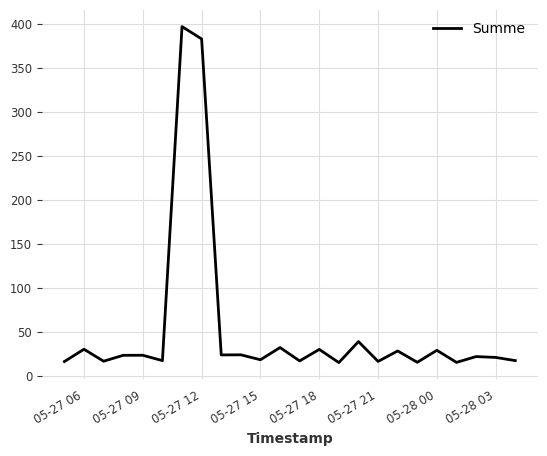

In [23]:
valid_series_input[:24].plot()

In [26]:
import matplotlib.pyplot as plt

# Assuming you have already imported your xgboost model and the required libraries

# Make predictions with the xgb_model on the first 24 elements of valid_series_input
predictions = xgb_model.predict(valid_series_input[:24])

# Plot the predictions with a label for the legend
plt.plot(predictions, label='Predicted Values')

# Plot the first 24 elements of valid_series_input with a label for the legend
plt.plot(valid_series_input[:24], label='Actual Values')

# Set the title of the plot
plt.title('XGBoost Model Predictions vs. Actual Values')

# Add a legend to the plot with titles
plt.legend(title='Legend')

# Show the plot
plt.show()


TypeError: 'TimeSeries' object cannot be interpreted as an integer